# Virtual Screening

---

*This notebook is a cut and slightly modified version of [TeachOpenCADD](https://github.com/volkamerlab/teachopencadd/tree/master) **T004**.*

---

The challenge in early stages of drug discovery is to narrow down a set of small molecules (molecules) from the large existing chemical space that are potentially binding to the target under investigation. Note that this chemical space is vast: Small molecules can be made of 10<sup>20</sup> combinations of chemical moieties ([<i>ACS Chem. Neurosci.</i> (2012), <b>19</b>, 649-57](https://www.ncbi.nlm.nih.gov/pubmed/23019491)). 

Since experimental high-throughput screening (HTS) for the activity of all those small molecules against the target of interest is cost and time intensive, computer-aided methods are invoked to propose a focused list of small molecules to be tested. This process is called virtual (high-throughput) screening: a large library of small molecules is filtered by rules and/or patterns, in order to identify those small molecules that are most likely to bind a target under investigation.

## Virtual screening using similarity search

Comparing a set of novel molecules against a (or several) known active molecule(s) to find the most similar ones can be used as a simple way of virtual screening. 
Given the similar property principle, we can assume that the most similar molecules, e.g. to a known inhibitor, also have similar effects. Requirements for a similarity search are the following (as discussed in detail above):

* A representation that encodes chemical/molecular features
* A potential weighting of features (optional)
* A similarity measurement

A similarity search can be performed by calculating the similarity between one molecule and all molecules in a specific dataset. Ranking the molecules of the dataset by their similarity coefficient yields the most similar molecules at the top.

To get started, we'll install rdkit and import the needed python packages.

In [40]:
!pip install rdkit
!pip install pandas
!pip install matplotlib
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
import pandas as pd
from matplotlib import pyplot as plt

### Load a data set

We import molecules from a *csv* file containing EGFR-tested molecules from the ChEMBL database (collected in TeachOpenCADD **T001**) which are filtered by Lipinski's rule of five (in **T002**). Given one query molecule (here Gefitinib), we screen that data set for similar molecules.

In [41]:
molecule_dataset = pd.read_csv("data/EGFR_compounds_lipinski.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],)
print(f"Number of molecules in dataset: {len(molecule_dataset)}")
molecule_dataset.head(5)

Number of molecules in dataset: 4635


,molecule_chembl_id,smiles,pIC50
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910


__Query__: For the query molecule Gefitinib, generate the rdkit `ROMol` object from the query molecule's SMILES.

In [58]:
query = Chem.MolFromSmiles("COC1=C(OCCCN2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C=C3)=NC=NC2=C1")
query

Now we have to generate the Morgan fingerprints for all molecules in our dataset.

In [43]:
fpgen = Chem.GetMorganGenerator(radius=2)

mols = [Chem.MolFromSmiles(s) for s in molecule_dataset["smiles"]]
fps = [fpgen.GetFingerprint(mol) for mol in mols]

And also for our query molecule (Gefitinib).

In [44]:
query_fp = fpgen.GetFingerprint(query)
list(query_fp)[:25]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Next, we calculate the Tanimoto similarity between the query molecule (Gefitinib) and all molecules our dataset (using the Morgan fingerprints).

In [45]:
molecule_dataset["tanimoto"] = DataStructs.BulkTanimotoSimilarity(query_fp, fps)

### Distribution of similarity values

We can have a look at the distributions by plotting a histogram of the Tanimoto similarity of the fingerprints.

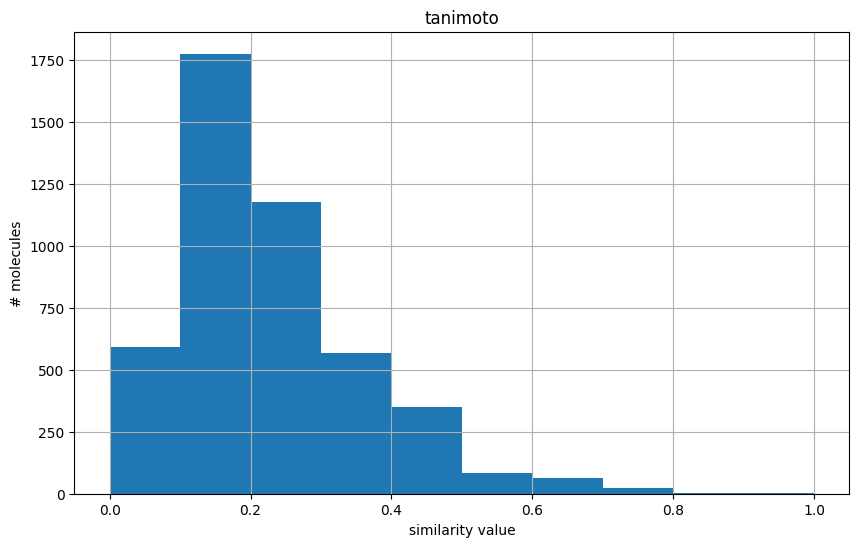

In [46]:
fig, axes = plt.subplots(figsize=(10, 6))
molecule_dataset.hist(["tanimoto"], ax=axes)
axes.set_xlabel("similarity value")
axes.set_ylabel("# molecules")
fig;

### Visualize most similar molecules

We visually inspect the structure of Gefitinib in comparison to the most similar molecules in our ranking, including the information about their bioactivity (pIC50 derived from the ChEMBL database in **T001**).

Here, we sort the `DataFrame` by the Tanimoto similarity based on Morgan fingerprints.

In [47]:
molecule_dataset.sort_values(["tanimoto"], ascending=False).head(3)

,molecule_chembl_id,smiles,pIC50,tanimoto
2639,CHEMBL939,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,6.288193,1.000000
880,CHEMBL14699,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN1CCOCC1,8.000000,0.919355
1747,CHEMBL299672,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCCC1,7.148742,0.857143


Show the query and its most similar molecules alongside the molecules' bioactivities.

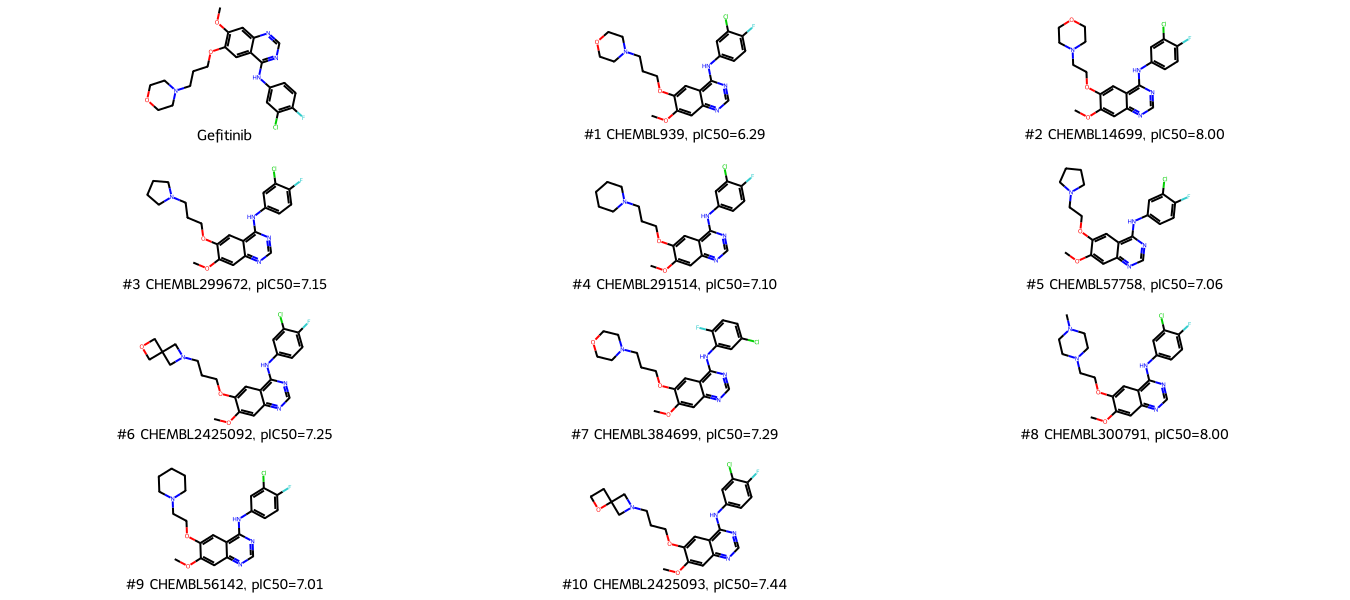

In [48]:
top_n_molecules = 10
top_molecules = molecule_dataset.sort_values(["tanimoto"], ascending=False).reset_index()
top_molecules = top_molecules[:top_n_molecules]
legends = [
    f"#{index+1} {molecule['molecule_chembl_id']}, pIC50={molecule['pIC50']:.2f}"
    for index, molecule in top_molecules.iterrows()
]
Draw.MolsToGridImage(
    mols=[query] + [Chem.MolFromSmiles(s) for s in top_molecules["smiles"]],
    legends=(["Gefitinib"] + legends),
    molsPerRow=3,
    subImgSize=(450, 150),
)

The top ranked molecules for Gefitinib are Gefitinib entries (rank 1 and 2) in our dataset, followed by alterations of Gefitinib, e.g. different benzole substitution patterns. 
Note: ChEMBL contains the complete structure-activity relationship analysis for Gefitinib (being a well-studied molecule), therefore it is not surprising to have that many Gefitinib-like molecules in our dataset.

We now check how well the similarity search is able to distinguish between active and inactive molecules based on our dataset. Therefore, we use the bioactivity values (these were collected from ChEMBL for each molecule (bioactivity against EGFR) in **T001**).

### Get enrichment

In order to decide whether we treat a molecule as active or inactive, we apply the commonly used pIC50 cutoff value of 6.3. Although there are several suggestions ranging from an pIC50 cutoff values of 5 to 7 in the literature or even to define an exclusion range, we think this cutoff is reasonable. 
(The same cutoff will be used for machine learning in **T010**.)

In [49]:
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    """
    Calculates x and y values for enrichment plot:
        x - % ranked dataset
        y - % true actives identified

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules with similarity values to a query molecule.
    similarity_measure : str
        Column name which will be used to sort the DataFrame．
    pic50_cutoff : float
        pIC50 cutoff value used to discriminate active and inactive molecules.

    Returns
    -------
    pandas.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of identified true actives.
    """

    # Get number of molecules in data set
    molecules_all = len(molecules)

    # Get number of active molecules in data set
    actives_all = sum(molecules["pIC50"] >= pic50_cutoff)

    # Initialize a list that will hold the counter for actives and molecules while iterating through our dataset
    actives_counter_list = []

    # Initialize counter for actives
    actives_counter = 0

    # Note: Data must be ranked for enrichment plots:
    # Sort molecules by selected similarity measure
    molecules.sort_values([similarity_measure], ascending=False, inplace=True)

    # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
    for value in molecules["pIC50"]:
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)

    # Transform number of molecules into % ranked dataset
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

    # Transform number of actives into % true actives identified
    actives_percentage_list = [i / actives_all for i in actives_counter_list]

    # Generate DataFrame with x and y values as well as label
    enrichment = pd.DataFrame(
        {
            "% ranked dataset": molecules_percentage_list,
            "% true actives identified": actives_percentage_list,
        }
    )

    return enrichment

Set the pIC50 cutoff used to discriminate active and inactive molecules... 

In [50]:
pic50_cutoff = 6.3

...and get the enrichment for Morgan fingerprints (using the Tanimoto similarity).

In [51]:
similarity_measures = ["tanimoto"]
enrichment_data = {
    similarity_measure: get_enrichment_data(molecule_dataset, similarity_measure, pic50_cutoff)
    for similarity_measure in similarity_measures
}

Show example enrichment data.

In [53]:
enrichment_data["tanimoto"].head()

,% ranked dataset,% true actives identified
0,0.000216,0.00000
1,0.000431,0.00038
2,0.000647,0.00076
3,0.000863,0.00114
4,0.001079,0.00152


### Enrichment Plots

Enrichment plots are used to validate virtual screening results, which display the ratio of active molecules detected in the top x% of the ranked list, i.e.: 

* the ratio of top-ranked molecules (x-axis) from the whole dataset vs. 
* the ratio of active molecules (y-axis) from the whole dataset.

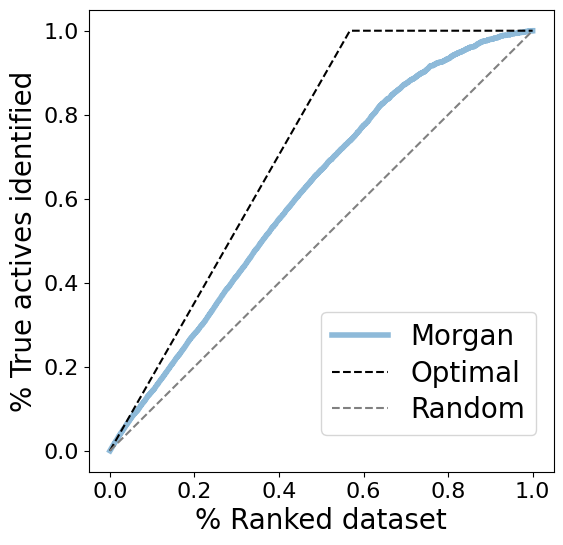

In [54]:
fig, ax = plt.subplots(figsize=(6, 6))

fontsize = 20

# Plot enrichment data
for similarity_measure, enrichment in enrichment_data.items():
    ax = enrichment.plot(
        ax=ax,
        x="% ranked dataset",
        y="% true actives identified",
        label=similarity_measure,
        alpha=0.5,
        linewidth=4,
    )
ax.set_ylabel("% True actives identified", size=fontsize)
ax.set_xlabel("% Ranked dataset", size=fontsize)

# Plot optimal curve: Ratio of actives in dataset
ratio_actives = sum(molecule_dataset["pIC50"] >= pic50_cutoff) / len(molecule_dataset)
ax.plot(
    [0, ratio_actives, 1],
    [0, 1, 1],
    label="Optimal curve",
    color="black",
    linestyle="--",
)

# Plot random curve
ax.plot([0, 1], [0, 1], label="Random curve", color="grey", linestyle="--")

plt.tick_params(labelsize=16)
plt.legend(
    labels=["Morgan", "Optimal", "Random"],
    loc=(0.5, 0.08),
    fontsize=fontsize,
    labelspacing=0.3,
)

plt.show()

### Calculate enrichment factors

The (experimental) __enrichment factor (EF)__ is used to access a methods success by a single number rather than a plot. The idea is to determine the percentage of active molecules in the top x% (e.g. 5%) of ranked molecules, as defined by the following helper function.

In [55]:
def calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff):
    """
    Get the experimental enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    enrichment : pd.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of
        identified true actives.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Experimental enrichment factor.
    """

    # Keep only molecules that meet the cutoff
    enrichment = enrichment[
        enrichment["% ranked dataset"] <= ranked_dataset_percentage_cutoff / 100
    ]
    # Get highest percentage of actives and the corresponding percentage of actives
    highest_enrichment = enrichment.iloc[-1]
    enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
    return enrichment_factor

This helper function calculates the random enrichment of active molecules in the top x% of ranked molecules (__random enrichment factor__).

In [35]:
def calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff):
    """
    Get the random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Random enrichment factor.
    """

    enrichment_factor_random = round(float(ranked_dataset_percentage_cutoff), 1)
    return enrichment_factor_random

And this helper function calculates the optimal enrichment of active molecules in the top x% of ranked molecules (__optimal enrichment factor__). The random and optimal enrichment factors are needed to judge how good the experimental enrichment factor for a method is.

In [36]:
def calculate_enrichment_factor_optimal(molecules, ranked_dataset_percentage_cutoff, pic50_cutoff):
    """
    Get the optimal random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    molecules : pandas.DataFrame
        the DataFrame with all the molecules and pIC50.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.
    activity_cutoff: float
        pIC50 cutoff value used to discriminate active and inactive molecules

    Returns
    -------
    float
        Optimal enrichment factor.
    """

    ratio = sum(molecules["pIC50"] >= pic50_cutoff) / len(molecules) * 100
    if ranked_dataset_percentage_cutoff <= ratio:
        enrichment_factor_optimal = round(100 / ratio * ranked_dataset_percentage_cutoff, 1)
    else:
        enrichment_factor_optimal = 100.0
    return enrichment_factor_optimal

We are ready to calculate the experimental enrichment factor (EF) for 5% of ranked dataset... 

In [57]:
ranked_dataset_percentage_cutoff = 5
for similarity_measure, enrichment in enrichment_data.items():
    enrichment_factor = calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff)
    print(
        f"Experimental EF for {ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
    )

Experimental EF for 5% of ranked dataset (tanimoto): 7.8%


... and we can compare it to the random and optimal enrichment factor.

In [56]:
enrichment_factor_random = calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff)
print(
    f"Random EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%"
)
enrichment_factor_optimal = calculate_enrichment_factor_optimal(
    molecule_dataset, ranked_dataset_percentage_cutoff, pic50_cutoff
)
print(
    f"Optimal EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%"
)
# NBVAL_CHECK_OUTPUT

Random EF for 5% of ranked dataset: 5.0%
Optimal EF for 5% of ranked dataset: 8.8%


## Discussion

We have learned how to use fingerprints and similarity measures to compare a query molecule with a dataset of molecules and rank the molecule by similarity. This approach is an example for virtual screening of molecules.
*Enrichment plots* (see TeachOpenCADD **T004**) and enrichment factors can be used to assess the performance. 

A drawback of a similarity search with molecular fingerprints is that it is based on molecular similarity and thus does not yield any novel structures. Another challenge when working with molecular similarity are so-called activity cliffs, i.e. a small change in a functional group of a molecule may initiate a jump in bioactivity. 